## Notebook to debug my stock predictor

In [ ]:
"""
The goal of this project is to use a LLM for sentiment analysis for a publically traded stock.
"""

# Import Libraries

# Financial Data
import yfinance as yf
from finvizfinance.quote import finvizfinance

# Data Manipulation
import pandas as pd
import numpy as np



# Machine Learning Library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Charts
#import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Interactive Web App UI
#import streamlit as st

# Connect to OpenAI API
from openai import OpenAI
from config import my_sk

# setup api client
client = OpenAI(api_key=my_sk)

# Open AI API Call using the LLM to classify text

In [2]:
def classify_sentiment(title):
    response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a sentiment classifier."},
                {"role": "user", "content": f"Classify the sentiment as 'POSITIVE' or 'NEGATIVE' or 'NEUTRAL' with just that one word only, no additional words or reasoning: {title}"},
            ],
        max_tokens=1,
        n=1,
        temperature=0.5
    )
    return response.choices[0].message.content# Directly access the .content attribute


Check to see if the sentiment analysis is working

In [3]:
#testing the classify_sentiment function    
classify_sentiment("IBM had an amazing run but tanked at the end of the day")

'NEG'

Function to check the if the ticker is valid. 

In [28]:
def validate_ticker(ticker, df):
  """
  Checks if a ticker symbol exists in a DataFrame.

  Args:
    ticker: The ticker symbol to validate.
    df: The Pandas DataFrame containing the list of valid ticker symbols.

  Returns:
    True if the ticker is valid, False otherwise.
  """
  return ticker in df["symbol"].values

Load all US pubblically traded companies into a dataframe

In [29]:
us_tickers_df = pd.read_csv('data/us_tickers.csv')

In [41]:
us_tickers_df.head()

,symbol,name,exchange,exchangeShortName,type,sector,industry,description,website
0,PMEGX,T. Rowe Price Institutional Mid-Cap Equity Gro...,Nasdaq,NASDAQ,trust,NaN,NaN,NaN,NaN
1,WT,"WisdomTree, Inc.",New York Stock Exchange,NYSE,stock,Financial Services,Asset Management,"WisdomTree, Inc., through its subsidiaries, op...",NaN
2,TFCCF,Terra Firma Capital Corporation,Other OTC,PNK,stock,Financial Services,Mortgage Finance,Terra Firma Capital Corporation provides real ...,NaN
3,EKWAX,Allspring Precious Metals Fund Class A,Nasdaq,NASDAQ,trust,NaN,NaN,NaN,NaN
4,RNWWW,ReNew Energy Global plc,NASDAQ Global Select,NASDAQ,stock,NaN,NaN,NaN,NaN


Validate the user input

In [ ]:
while True:
  ticker = input("Enter a publicly traded company name or stock ticker (or type 'exit'): ").upper()
  
  if ticker == "EXIT":
    print(f"Thank you for trying, goodbye!")
    break  # Exit the loop if the user types 'exit'

  if validate_ticker(ticker, us_tickers_df):
    print(f"{ticker} is a valid ticker symbol.")
    break # Exit the loop and continue with the rest of the code
  else:
    print(f"{ticker} is not a valid ticker symbol. Please check your input or type EXIT.")

BLAH is not a valid ticker symbol. Please check your input or type EXIT.
HELLO is not a valid ticker symbol. Please check your input or type EXIT.
IBM is a valid ticker symbol.


In [42]:
# Import Data using the APIs
# Data Pull
print(f"Pulling latest news for {ticker}...")

try:
    stock = finvizfinance(ticker) 
    news_df = stock.ticker_news()
    print(f"Successfully pulled {len(news_df)} news articles for {ticker}.")
    print(news_df.head())
except Exception as e:
    print(f"An error occurred while fetching news for {ticker}: {e}")

Pulling latest news for IBM...
Successfully pulled 100 news articles for IBM.
                 Date                                              Title  \
0 2024-11-29 17:45:00  IBM (IBM) Gains But Lags Market: What You Shou...   
1 2024-11-29 07:37:00  Better Artificial Intelligence Stock: Palantir...   
2 2024-11-29 04:08:00  Should You Forget C3.ai and Buy These 2 AI Sto...   
3 2024-11-28 08:51:00                                Is IBM Stock a Buy?   
4 2024-11-27 12:22:00  Are IONQ, FORM, and IBM Stocks Buys Ahead of t...   

                                                Link       Source  
0  https://finance.yahoo.com/news/ibm-ibm-gains-l...        Zacks  
1  https://finance.yahoo.com/m/11b4fe8a-b783-3600...  Motley Fool  
2  https://finance.yahoo.com/m/35165ee8-4356-3c3b...  Motley Fool  
3  https://finance.yahoo.com/m/6a4946cf-ce52-3028...  Motley Fool  
4  https://finance.yahoo.com/news/ionq-form-ibm-s...     TipRanks  


In [43]:
# Preprocess before putting into LLM
news_df['Title'] = news_df['Title'].str.lower()

# Classify Sentiment function applied to each row of news_df
news_df['sentiment'] = news_df['Title'].apply(classify_sentiment)

# Postprocess after putting into LLM
news_df['sentiment'] = news_df['sentiment'].str.upper()
news_df = news_df[news_df['sentiment'] != 'NEUTRAL']
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_df['DateOnly'] = news_df['Date'].dt.date

In [52]:
print(news_df.head())
news_df['sentiment'].value_counts()
#news_df.isnull().sum()

                 Date                                              Title  \
0 2024-11-29 17:45:00  ibm (ibm) gains but lags market: what you shou...   
1 2024-11-29 07:37:00  better artificial intelligence stock: palantir...   
2 2024-11-29 04:08:00  should you forget c3.ai and buy these 2 ai sto...   
3 2024-11-28 08:51:00                                is ibm stock a buy?   
4 2024-11-27 12:22:00  are ionq, form, and ibm stocks buys ahead of t...   

                                                Link       Source sentiment  \
0  https://finance.yahoo.com/news/ibm-ibm-gains-l...        Zacks        NE   
1  https://finance.yahoo.com/m/11b4fe8a-b783-3600...  Motley Fool        NE   
2  https://finance.yahoo.com/m/35165ee8-4356-3c3b...  Motley Fool        NE   
3  https://finance.yahoo.com/m/6a4946cf-ce52-3028...  Motley Fool        NE   
4  https://finance.yahoo.com/news/ionq-form-ibm-s...     TipRanks        NE   

     DateOnly  
0  2024-11-29  
1  2024-11-29  
2  2024-11-29  
3  2

sentiment
NE     48
POS    37
NEG    15
Name: count, dtype: int64

Visulizations for the Sentiment Analysis

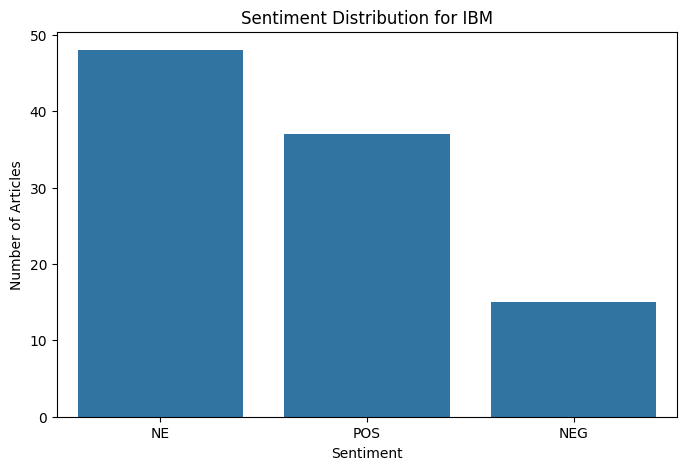

In [55]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=news_df)
plt.title(f"Sentiment Distribution for {ticker}")
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")
plt.show()

Word Cloud for the Sentiment Analysis

In [ ]:
# Combine all the titles into a single string
text = " ".join(news_df['Title'].tolist())

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 1    


SyntaxError: invalid non-printable character U+00A0 (4054539557.py, line 11)